# PnL Analysis with Python and Pandas
Our goal is to put together a PnL analysis like the one below for Mike Power Housing Inc.(?). We'll read in expenses and income from various sources and explore some basic functionality of the `pandas` library to calculate the results like <b>Total Expenses</b> and <b>Net Income</b>.

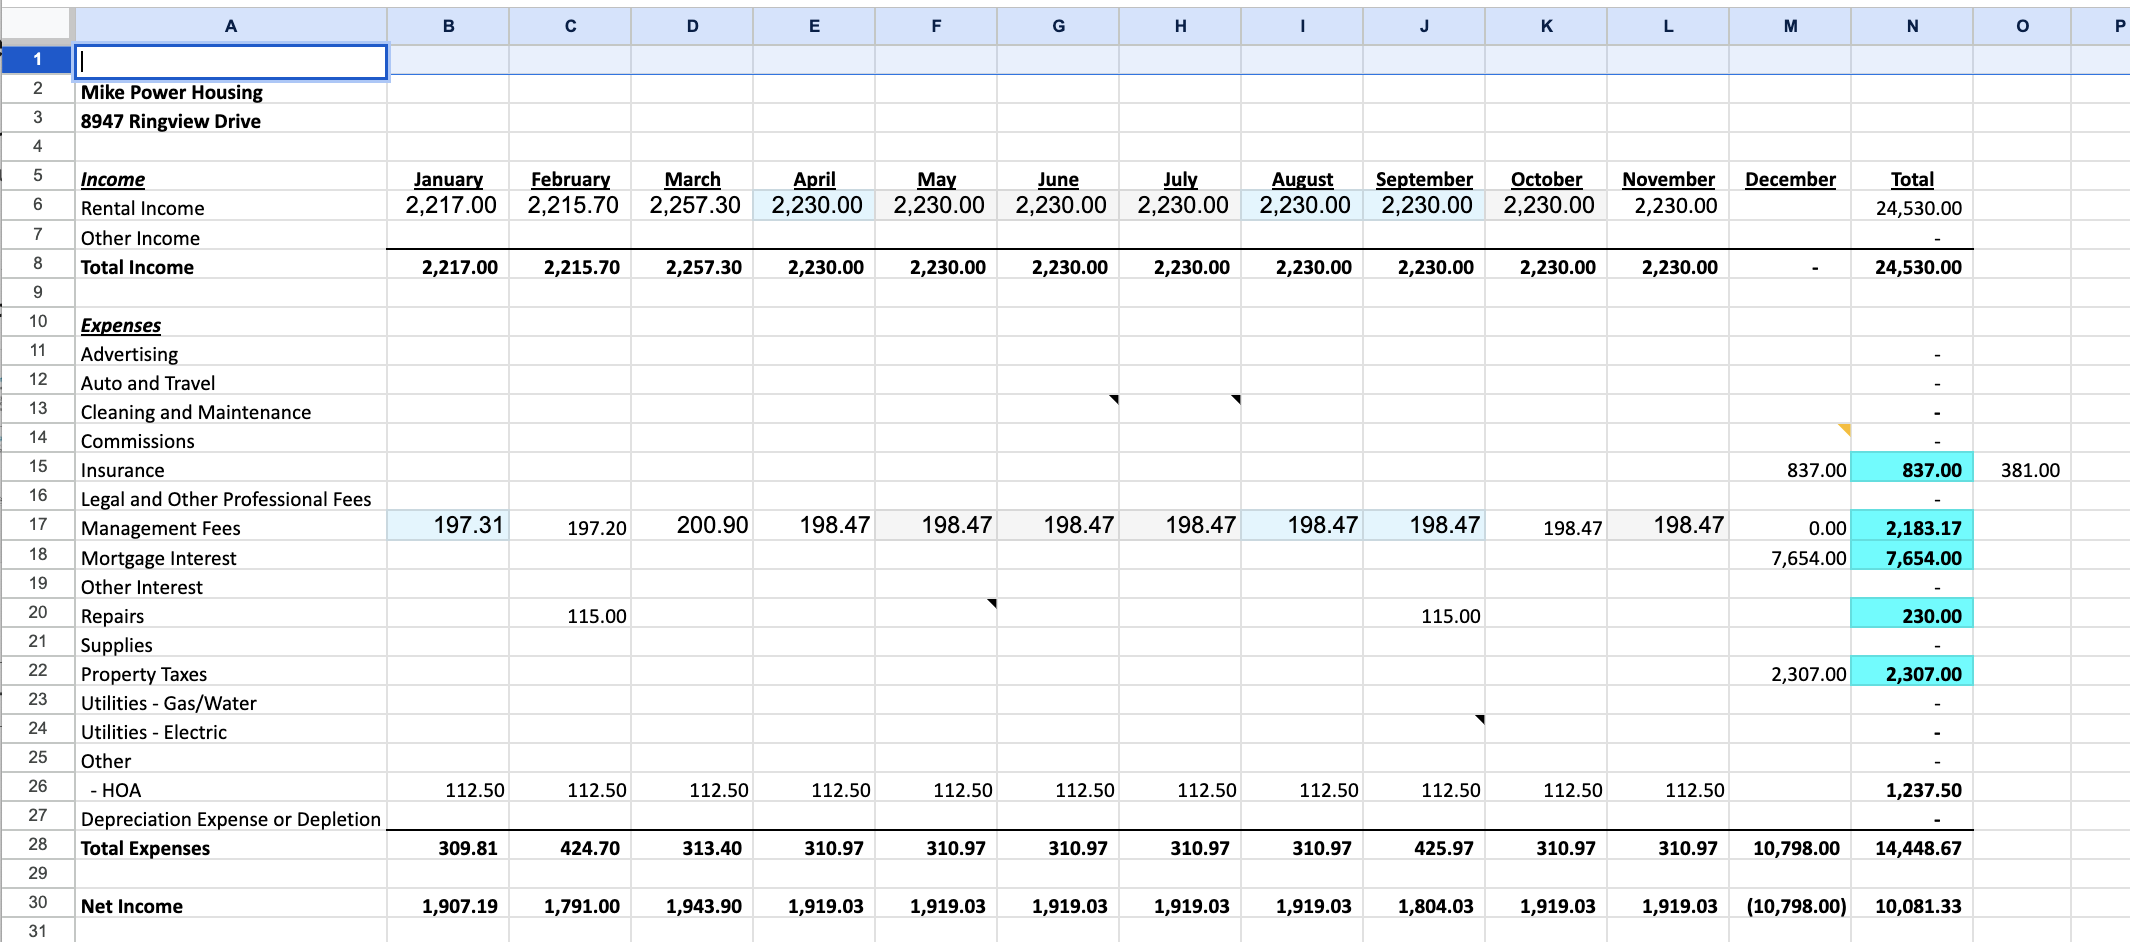
### Load Income and Expenses into a Pandas DataFrame 
Lets start by reading in a `.csv` file containing HOA costs, taxes, and insurance premiums

In [ ]:
# Declare python libaries or modules we want to use
import pandas as pd
from datetime import datetime

# Hardcode the file name
tax_ins_hoa_expenses_file_location = "tax_ins_hoa_expenses.csv"

# Use pandas to read in the csv file given its location
df = pd.read_csv(tax_ins_hoa_expenses_file_location,  index_col=0)
df

The month is the index of the dataframe - it has a unique value per row and is used to access data elements or cells

In [ ]:
# Inspect the values and type of a DataFrame's index
df.index

In [ ]:
# Use pandas.DataFrame.loc with square brackets to access a particular row by its index
df.loc['2023-06-01']

Next set the monthly incomes manually by appending a column to the existing DataFrame

In [ ]:
incomes = [
    2217,
    2215.70,
    2257.30,
    2230,
    2230,
    2230,
    2230,
    2230,
    2230,
    2230,
    2230,
    0
]

df['RentalIncome'] = incomes
df

Oops, HOA should be $0 in December. Modify a single cell as follows:

In [ ]:
df.at['2023-12-01','HOA'] = 0
df

In [ ]:
# Add mortgage interest manually
df['MortgageInterest'] = [7654/12. for x in range(12)]
df.head()

## Load Management Fees and Repairs Costs

In [ ]:
import os
import copy

# Use the os module to get all file names inside of PropertyManagementStatements
pm_dir = 'PropertyManagementStatements'
statement_files = [pdf_doc for pdf_doc in os.listdir(pm_dir) if pdf_doc.endswith(".pdf")]
statement_files

In [ ]:
from tabula import read_pdf

# Use tabula read_pdf function to read tables from a statement pdf 
# into pandas dataframes
df_stmt = read_pdf(os.path.join(pm_dir, statement_files[0]), pages='all', lattice=True)

# Show the second table in the document
df_stmt[1].head()

In [ ]:
# Define a function to remove commas from the dollar amounts in the pdfs and cast them to float
def str_to_float(str_val):
    if not isinstance(str_val, str):
        return str_val
    return float(str_val.replace(",",""))

# Define two empty lists to hold records of each non-management fee expense 
# and monthly summary statistics (total income, management fees, other expenses)
expenses_dfs = []
stmt_summary_dfs = []

for stmt in statement_files:
    # Infer the file path of the pdf and read it in
    file_path = os.path.join(pm_dir, stmt)
    dfs = read_pdf(file_path, pages='all', lattice=True)
    df_entries = dfs[1]

    # Clean 'Cash In' and 'Cash Out' columns read in from statement pdfs
    df_entries['Cash In'] = df_entries.apply(lambda x: str_to_float(x['Cash In']), axis=1)
    df_entries['Cash Out'] = df_entries.apply(lambda x: str_to_float(x['Cash Out']), axis=1)

    # Remove null values and replace them with blank strings
    df_entries['Description'].fillna("", inplace=True)

    # Infer the month from the first 3 characters of the pdf file name
    # Ex: "Apr 01, 2023 to Apr 30, 2023.pdf"
    month = stmt[:3]

    # Sum income, management fees, other expenses for the month
    income = df_entries['Cash In'].fillna(0).sum()
    mgmt_fees = df_entries[df_entries['Description'].str.contains('Management Fees')]['Cash Out'].fillna(0).sum()
    other_expenses_df = df_entries[(~df_entries['Description'].str.contains('Owner Draws')) \
                                    & (~df_entries['Description'].str.contains('Management Fees')) \
                                    & (~df_entries['Cash Out'].isna())]
    other_expenses_total = other_expenses_df['Cash Out'].fillna(0).sum()

    # Save off individual non-management fee expense entries to expenses_dfs list
    expenses_dfs.append(copy.deepcopy(other_expenses_df))

    # Save off the month's summary statistics
    stmt_summary_dfs.append(
        pd.DataFrame(
            {
                "Month" : [month],
                "Income" : [income],
                "Mgmt Fees" : [mgmt_fees],
                "Other Expenses" : [other_expenses_total]
            }
        )
    )

all_non_mgmt_expenses = pd.concat(expenses_dfs)
stmt_summ_df = pd.concat(stmt_summary_dfs)

# Look at all expenses besides management fees - just a couple property evaluations
all_non_mgmt_expenses

In [ ]:
# And the monthly summaries
stmt_summ_df

In [ ]:
# Reorder stmt_summ_df chronologically
import calendar

# Create a string column representing the first date of the month
# in the same format as our income, HOA, etc. DataFrame
stmt_summ_df['MonthBegin'] = stmt_summ_df.apply(
    lambda x: f"2023-{list(calendar.month_abbr).index(x['Month']):02d}-01", 
    axis=1
)

# Create a datetime month column for sorting
stmt_summ_df['MonthDt'] = pd.to_datetime(stmt_summ_df['MonthBegin'])

# Sort by month using the datetime column
stmt_summ_df.sort_values(by='MonthDt', inplace=True)
stmt_summ_df

## Join Management Fees and Repairs Costs with Income, HOA, etc.

In [ ]:
# Create date column in df using its index
df['MonthBegin'] = df.index
pnl_inputs_df = df.merge(
    stmt_summ_df[['Mgmt Fees','Other Expenses','MonthBegin','MonthDt']],
    how='left',
    on='MonthBegin'
)

pnl_inputs_df.index = pnl_inputs_df['MonthBegin']
pnl_inputs_df.index.name = None
del pnl_inputs_df['MonthBegin']
pnl_inputs_df

## Aggregate Monthly Income and Expenses

In [ ]:
# Income
pnl_inputs_df['Total_Income'] = pnl_inputs_df['RentalIncome']

# Expenses
pnl_inputs_df['Expenses'] = pnl_inputs_df['HOA'] + pnl_inputs_df['Insurance'] \
                          + pnl_inputs_df['Mgmt Fees'].fillna(0) + pnl_inputs_df['Other Expenses'].fillna(0) \
                          + pnl_inputs_df['PropertyTaxes'] + pnl_inputs_df['MortgageInterest']

pnl_inputs_df

In [ ]:
# Calculate monthly net income
pnl_inputs_df['Net_Income'] = pnl_inputs_df['Total_Income'] - pnl_inputs_df['Expenses']
pnl_inputs_df

In [ ]:
# Annual Profit (or loss)
pnl_inputs_df['Net_Income'].sum()

## Appendix
Build the `tax_ins_hoa_expenses.csv` used in this demo from scratch using `pandas`

In [ ]:
import pandas as pd
from datetime import datetime

df = pd.DataFrame(columns=["HOA", "Insurance", "PropertyTaxes"], 
                  index=[datetime(2023,idx,1) for idx in range(1,13)])
df['HOA'] = 112.50
df['Insurance'] = 837/12.
df['PropertyTaxes'] = 2307/12.

df.to_csv("tax_ins_hoa_expenses.csv")